In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
from tqdm import tqdm
import torch
from torch.distributions import MultivariateNormal

from sbi.inference import FMPE
from sbi.utils import BoxUniform
import sbibm

from lf2i.inference import LF2I
from lf2i.test_statistics.posterior import Posterior
from lf2i.utils.other_methods import hpd_region
from lf2i.plot.parameter_regions import plot_parameter_regions

from utils import posterior_and_prior_kdeplot

2024-11-01 16:46:25.609706: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-01 16:46:25.609761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-01 16:46:25.611365: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-01 16:46:25.619865: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-01 16:46:26.772369: W tensorflow/compiler/tf2

In [3]:
POI_DIM = 2  # parameter of interest
PRIOR_LOC = [0, 0]
PRIOR_VAR = 2.0

FLOW_TYPE = 'fmpe'
B = 100_000  # num simulations to estimate posterior and test statistics
B_PRIME = 30_000  # num simulations to estimate critical values
EVAL_GRID_SIZE = 50_000  # num evaluation points over parameter space to construct confidence sets
CONFIDENCE_LEVEL = 0.9

NORM_POSTERIOR_SAMPLES = None

DEVICE = 'cpu'
# for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [4]:
task = sbibm.get_task('gaussian_mixture')
prior = MultivariateNormal(
    loc=torch.Tensor(PRIOR_LOC), covariance_matrix=PRIOR_VAR*torch.eye(n=POI_DIM)
)
simulator = task.get_simulator()

In [5]:
b_params = prior.sample(sample_shape=(B, ))
b_samples = simulator(b_params.cpu())  # cast to cpu cause simulator does not appear to support GPU
b_params.shape, b_samples.shape

(torch.Size([100000, 2]), torch.Size([100000, 2]))

In [6]:
estimator = FMPE(
    prior=prior,
    device=DEVICE
)
_ = estimator.append_simulations(b_params, b_samples).train()
posterior = estimator.build_posterior()

 Neural network successfully converged after 69 epochs.

In [8]:
with open(f'./outputs/{FLOW_TYPE}_gaussPrior.pkl', 'wb') as f:
    pickle.dump(posterior, f)

In [9]:
idx_obs = 10  # 1 to 10
true_theta = task.get_true_parameters(idx_obs)
true_x = task.get_observation(idx_obs)

In [10]:
samples_posterior = posterior.sample((100_000,), x=true_x)
samples_prior = prior.sample(sample_shape=(100_000, ))

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

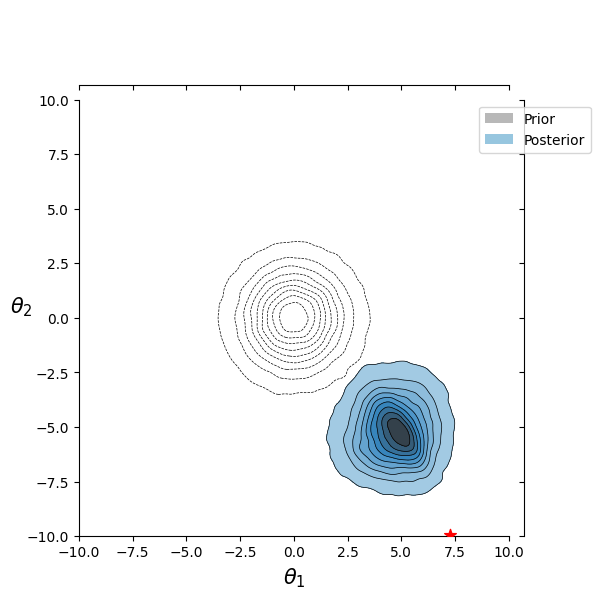

In [11]:
posterior_and_prior_kdeplot(
    samples_prior, samples_posterior, true_theta, plot_marginals=False
)

## LF2I

In [12]:
# used to sample simulations for quantile regression and for evaluation grid
reference = BoxUniform(low=torch.Tensor([-10, -10]), high=torch.Tensor([10, 10]))
eval_grid = reference.sample(sample_shape=(EVAL_GRID_SIZE, ))

b_prime_params = reference.sample(sample_shape=(B_PRIME, ))
b_prime_samples = simulator(b_prime_params)
b_prime_params.shape, b_prime_samples.shape

(torch.Size([30000, 2]), torch.Size([30000, 2]))

In [13]:
lf2i = LF2I(
    test_statistic=Posterior(
        poi_dim=POI_DIM, estimator=posterior, norm_posterior_samples=NORM_POSTERIOR_SAMPLES
    )
)

In [14]:
confidence_sets = lf2i.inference(
    x=torch.vstack([task.get_observation(i) for i in range(1, 11)]),  # each task contains 10 benchmark observations
    evaluation_grid=eval_grid,
    confidence_level=CONFIDENCE_LEVEL,
    calibration_method='critical-values',
    calibration_model='cat-gb',
    calibration_model_kwargs={
        'cv': {'iterations': [100, 300, 500, 700, 1000], 'depth': [1, 3, 5, 7, 9]},
        'n_iter': 25
    },
    T_prime=(b_prime_params, b_prime_samples),
    retrain_calibration=False
)


Calibration ...


Evaluating posterior for 30000 points ...: 100%|██████████| 30000/30000 [05:47<00:00, 86.43it/s] 


Fitting 5 folds for each of 25 candidates, totalling 125 fits


TBB Warning: The number of workers is currently limited to 15. The request for 255 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.

TBB Warning: The number of workers is currently limited to 15. The request for 255 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.

TBB Warning: The number of workers is currently limited to 15. The request for 255 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.

TBB Warning: The number of workers is currently limited to 15. The request for 255 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.

TBB Warning: The number of workers is currently limited to 15. The request for 255 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.

TBB Warning: The number of workers is currently limited to 1


Constructing confidence regions ...


Evaluating posterior for 10 points ...: 100%|██████████| 10/10 [02:38<00:00, 15.85s/it]


In [15]:
credible_regions = [
    hpd_region(
        posterior=lf2i.test_statistic.estimator,
        param_grid=eval_grid,
        x=task.get_observation(i), # x_obs[i, :],
        credible_level=CONFIDENCE_LEVEL,
        num_level_sets=10_000,
    )
    for i in tqdm(range(1, 11))
]

100%|██████████| 10/10 [02:17<00:00, 13.75s/it]


In [20]:
credible_regions[idx_obs-1][1]

tensor([[-5.5609, -0.5786],
        [-8.1846, -2.3463],
        [-5.1914,  0.1161],
        ...,
        [-5.3609,  0.1170],
        [-5.4321,  0.5711],
        [-8.4289, -0.5914]])

In [21]:
confidence_sets[idx_obs-1]

array([[-5.560931  , -0.57857895],
       [-8.184558  , -2.346313  ],
       [-5.191369  ,  0.11613274],
       ...,
       [-5.360918  ,  0.11696053],
       [-5.4320917 ,  0.5710888 ],
       [-8.428913  , -0.59141064]], dtype=float32)

/home/export/jcarzon/vsi/lf2i/src/lf2i/plot/parameter_regions.py:154: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")


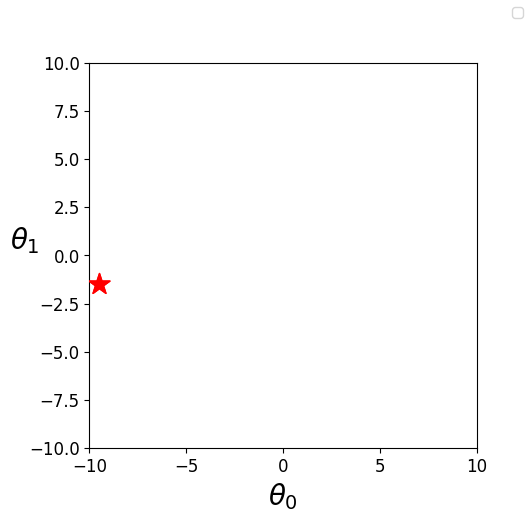

In [18]:
idx_obs = 1  # 1 to 10

plot_parameter_regions(
    credible_regions[idx_obs-1][1], confidence_sets[idx_obs-1],
    param_dim=POI_DIM,
    true_parameter=task.get_true_parameters(idx_obs),
    parameter_space_bounds={r'$\theta_0$': {'low': -10, 'high': 10}, r'$\theta_1$': {'low': -10, 'high': 10}},
    region_names=['HPD Region', f'LF2I-Posterior'],
    param_names=[r'$\theta_0$', r'$\theta_1$'],
    labels=[r'$\theta_0$', r'$\theta_1$'],
    colors=['blue', 'green'],
    alpha_shape=False,
    alpha=4,
    scatter=False,
    figsize=(5, 5),
    #save_fig_path=f'../../results/figures/gaussian_mixture/nsf_maf_comparison/posterior_nsf_obs{idx_obs}.pdf'
)

/home/export/jcarzon/vsi/lf2i/src/lf2i/plot/parameter_regions.py:154: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")
/home/export/jcarzon/vsi/lf2i/src/lf2i/plot/parameter_regions.py:154: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")
/home/export/jcarzon/vsi/lf2i/src/lf2i/plot/parameter_regions.py:154: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnin

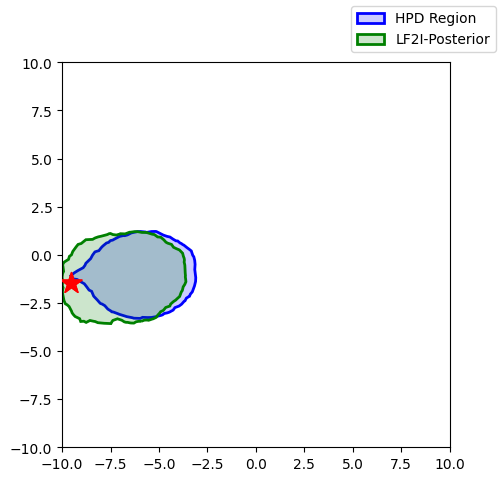

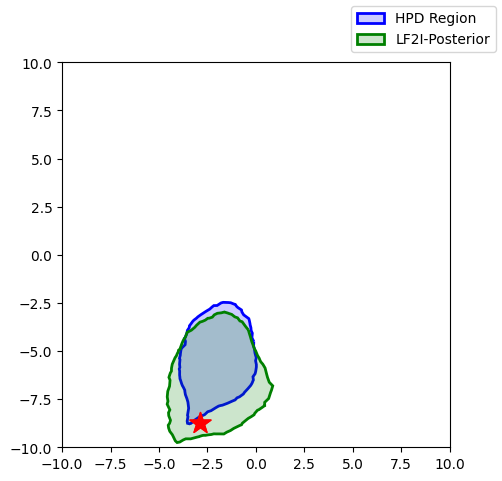

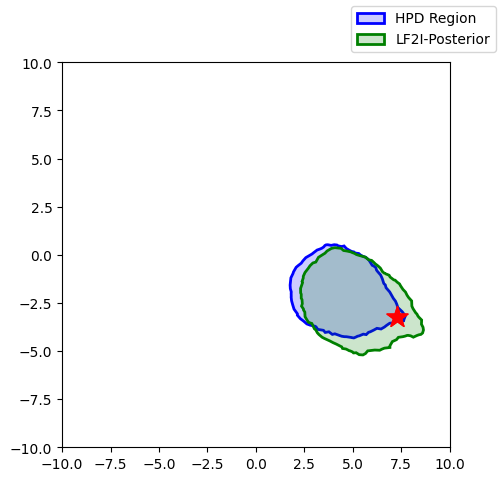

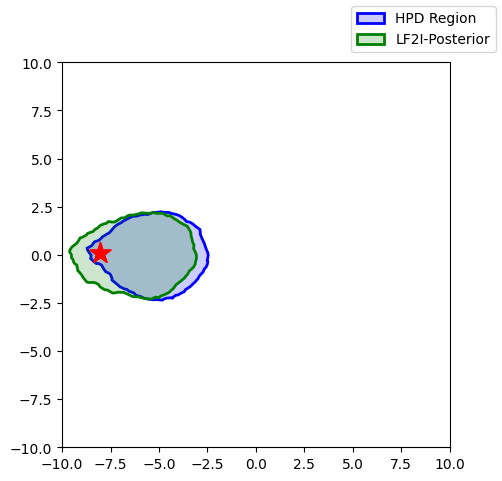

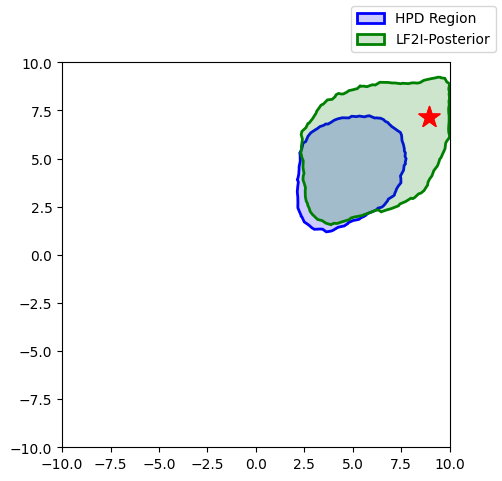

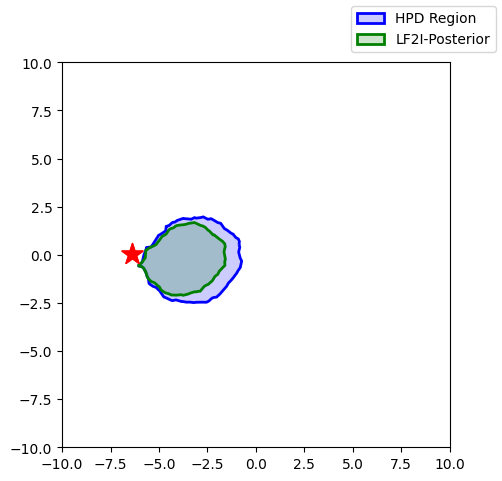

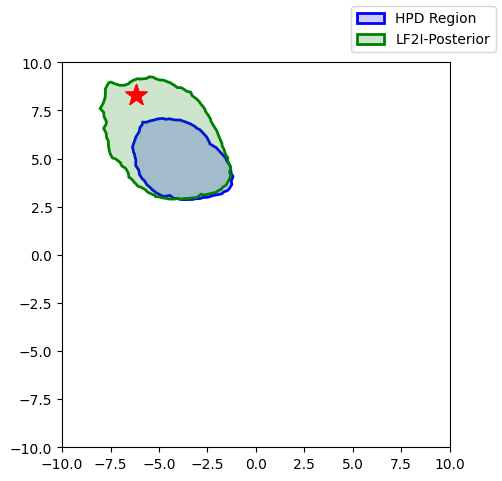

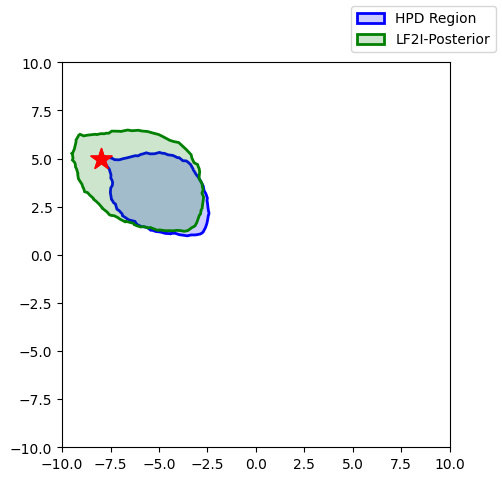

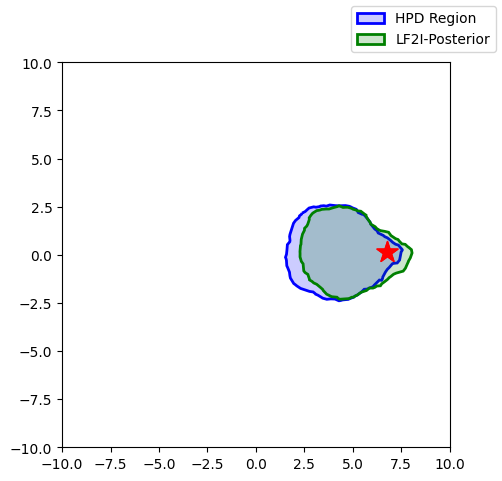

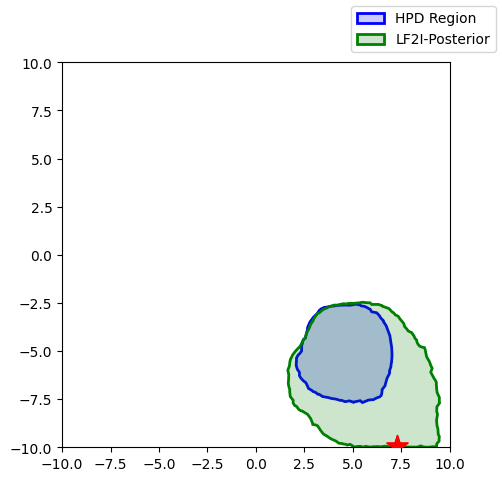

In [23]:
for idx_obs in range(1, 11):
    try:
        plot_parameter_regions(
            credible_regions[idx_obs-1][1], confidence_sets[idx_obs-1],
            param_dim=POI_DIM,
            true_parameter=task.get_true_parameters(idx_obs),
            parameter_space_bounds={r'$\theta_0$': {'low': -10, 'high': 10}, r'$\theta_1$': {'low': -10, 'high': 10}},
            region_names=['HPD Region', f'LF2I-Posterior'],
            param_names=[r'$\theta_0$', r'$\theta_1$'],
            labels=[r'$\theta_0$', r'$\theta_1$'],
            colors=['blue', 'green'],
            alpha_shape=True,
            alpha=4,
            scatter=False,
            figsize=(5, 5),
            #save_fig_path=f'../../results/figures/gaussian_mixture/nsf_maf_comparison/posterior_nsf_obs{idx_obs}.pdf'
        )
    except AttributeError:
        continue